## Lake Zug APhys-AChem Meeting (02.02.2026)

In [1]:
# imports
import ewgreaders as ewg
import os
from glob import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
lake = 'Zugersee'
year = '2026'
serial_id = '1807'

### CTD

Profiles from 28.1, 30.1.

In [3]:
def extract_profile_locations(dpath_L1, oom=True):
    profile_locs = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # Swiss coordinates
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)

        # bathymetry
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()
        
        profile_locs.append({
            'name': ds.attrs['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(profile_locs).sort_values('ysc', ascending=False).reset_index(drop=True), bathy


def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()


def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        elif var == 'SALIN':
            mask = (ds['depth'].notnull()) & (ds['Cond_qual'] == 0)
        else:
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        if var == 'DO_mg':    # convert to umol/L
            vals *= (1000/32)

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)


def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'
    elif var == 'rho':
        color = 'orange'
    elif var == 'Turb':
        color = 'brown'
    elif var == 'Cond':
        color = 'purple'
    elif var == 'SALIN':
        color = 'red'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        fig.supxlabel('Density [kg/m^3]')
    elif var == 'Turb':
        fig.supxlabel('Turbidity [FTU]')
    elif var == 'Cond':
        fig.supxlabel('Conductivity [mS/cm]')
    elif var == 'SALIN':
        fig.supxlabel('Salinity [ppt]')

    plt.tight_layout(w_pad=0.5)
    plt.show()


def plot_profiles_overlay(data, var, locs):
    df = data[data['name'].isin(locs)]

    fig, ax = plt.subplots(figsize=(7, 5))

    for t, dat in df.groupby('time', sort=False):
        ax.plot(dat[var], dat['depth'], label=f"{dat['name'].unique()[0]} | {t}")

    if var == 'Temp':
        ax.set_xlabel('Temperature [°C]')
    elif var == 'DO_mg':
        ax.set_xlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        ax.set_xlabel('Density [kg/m^3]')
    ax.set_ylabel('Depth [m]')
    ax.set_title(f'Profile Locations {locs}')

    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.legend()
    ax.invert_yaxis()

    plt.show()


def calculate_transect_min_do(dpath_L1):
    # transect minimum
    min_do = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        do = ds['DO_mg'][mask]
        min_do.append(do.min().item())

    return min(min_do)


def calculate_anoxia(dpath_L1, err=0.2, oom=True):
    min_do = calculate_transect_min_do(dpath_L1)

    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        depth = ds['depth'][mask]
        do = ds['DO_mg'][mask]

        try:
            idx = np.where(do <= min_do + err)[0][0]
            z = depth[idx].item()
        except IndexError:
            z = np.nan

        data.append({
            'anoxic_z': z,
            'name': name,
            'time': time,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)


def plot_anoxia(data, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.lineplot(df, x='ysc', y='anoxic_z', color='limegreen', marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_title('Anoxic Zone')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()


#### 28.01.2026

In [4]:
date = '20260128'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

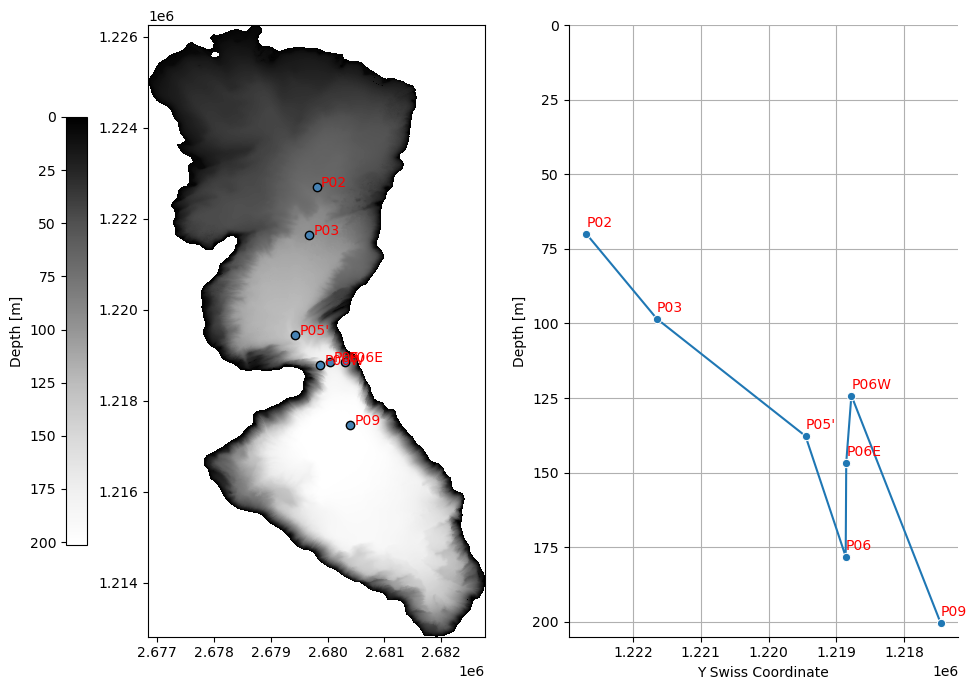

In [5]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [6]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')
rho_data = extract_data_vars(dpath_L1, 'rho')
cond_data = extract_data_vars(dpath_L1, 'Cond')
salin_data = extract_data_vars(dpath_L1, 'SALIN')

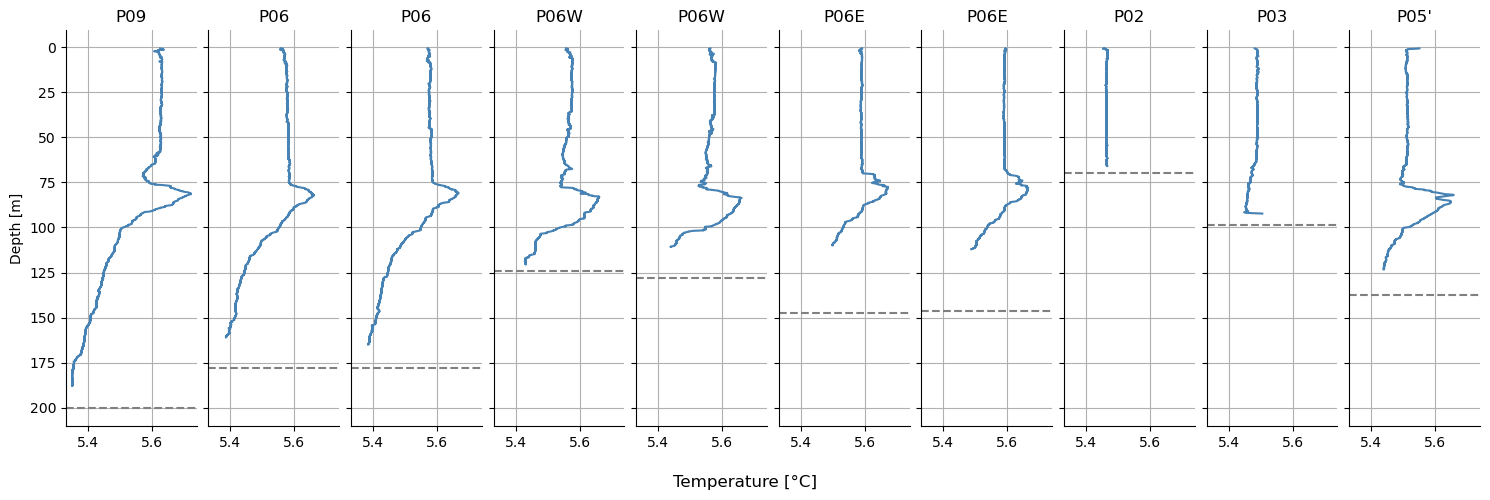

In [7]:
plot_profiles_transect(temp_data, 'Temp')

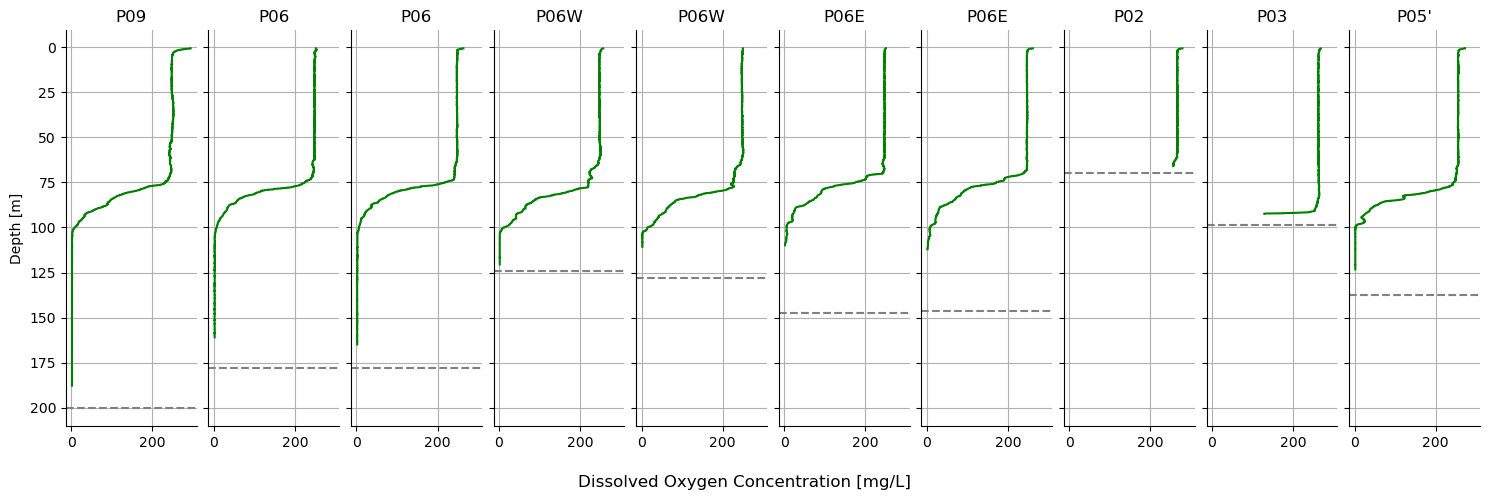

In [8]:
plot_profiles_transect(do_data, 'DO_mg')

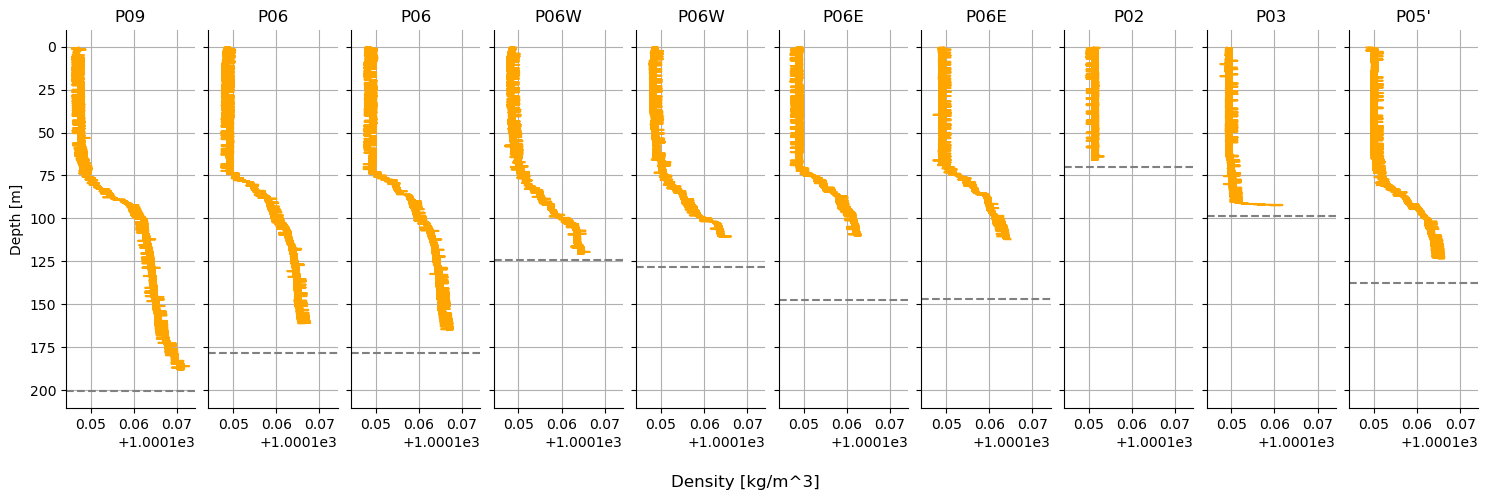

In [9]:
plot_profiles_transect(rho_data, 'rho')

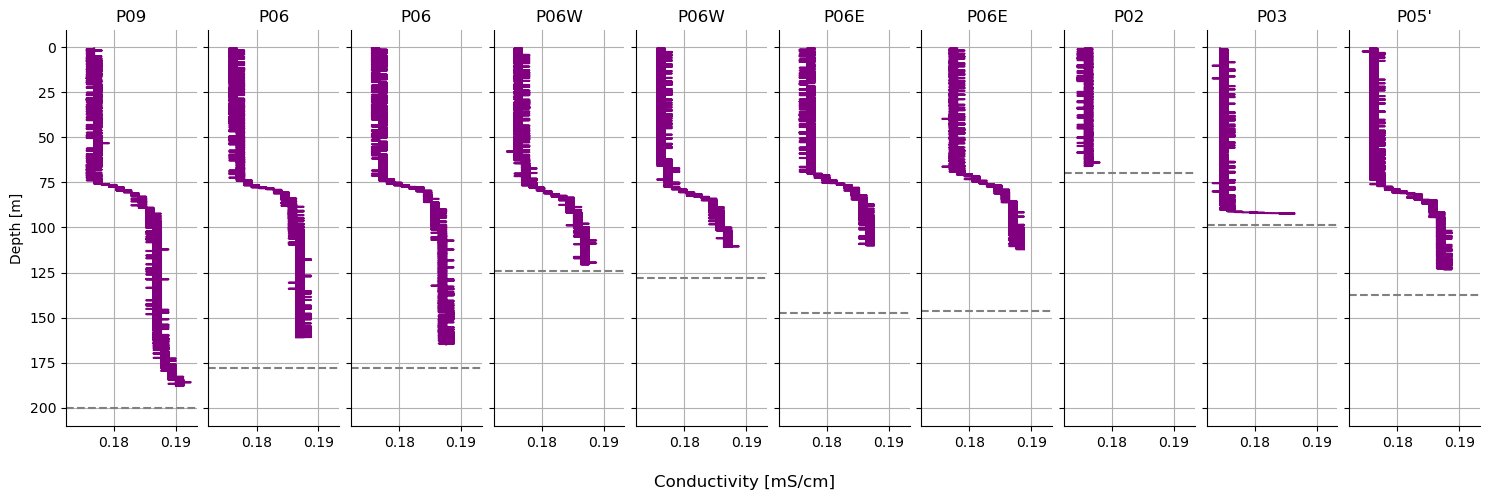

In [10]:
plot_profiles_transect(cond_data, 'Cond')

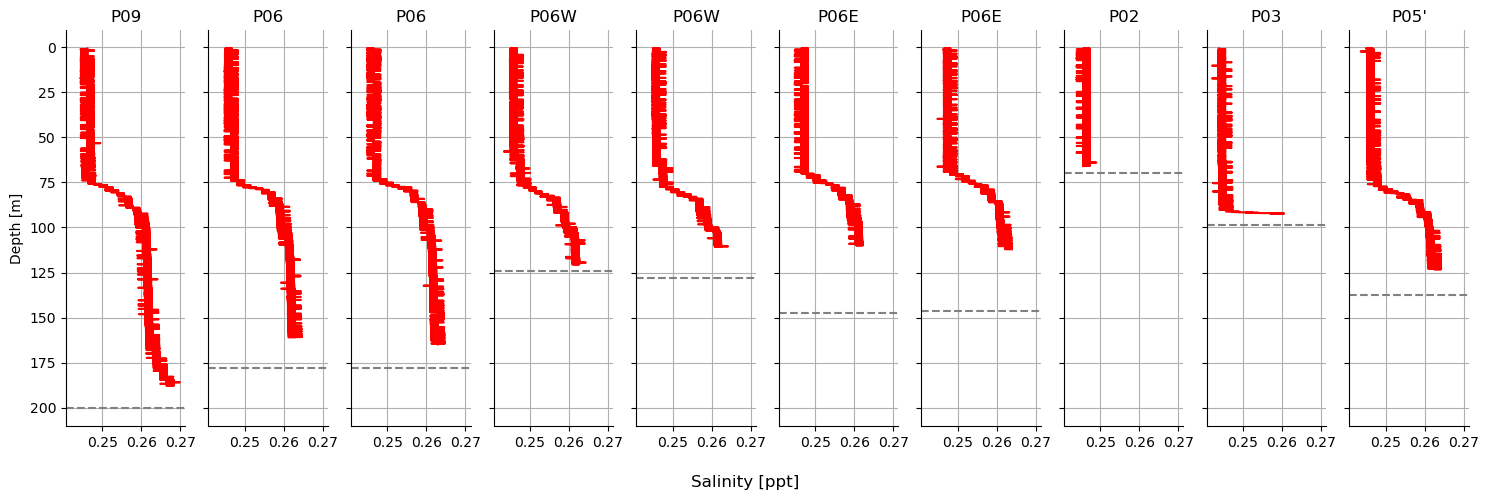

In [11]:
plot_profiles_transect(salin_data, 'SALIN')

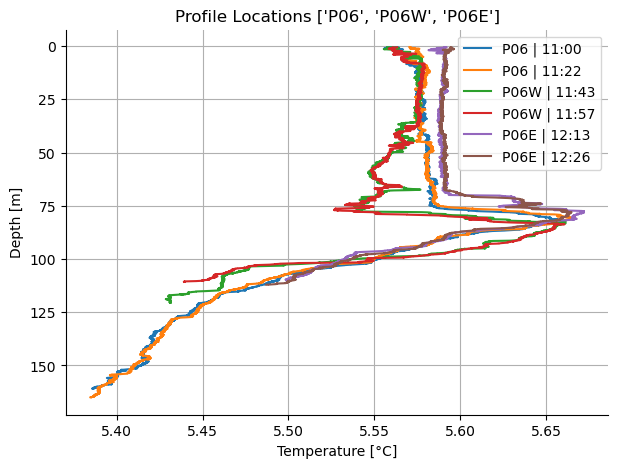

In [11]:
plot_profiles_overlay(temp_data, 'Temp', ["P06", "P06W", "P06E"])

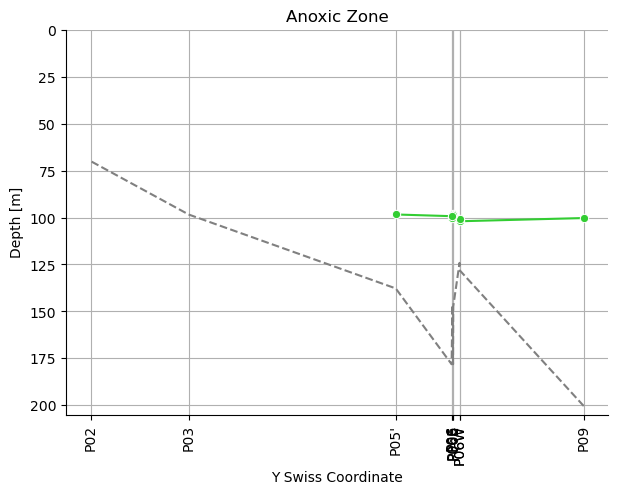

In [12]:
anoxic_data = calculate_anoxia(dpath_L1)
plot_anoxia(anoxic_data)

#### 30.01.2026

In [13]:
date = '20260130'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

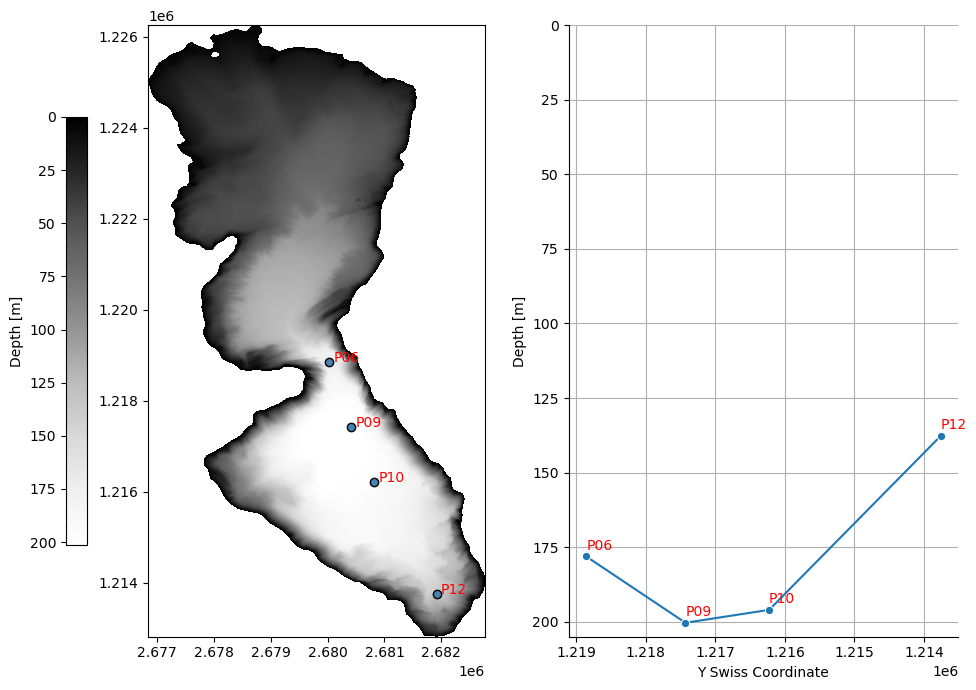

In [14]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [15]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')
rho_data = extract_data_vars(dpath_L1, 'rho')

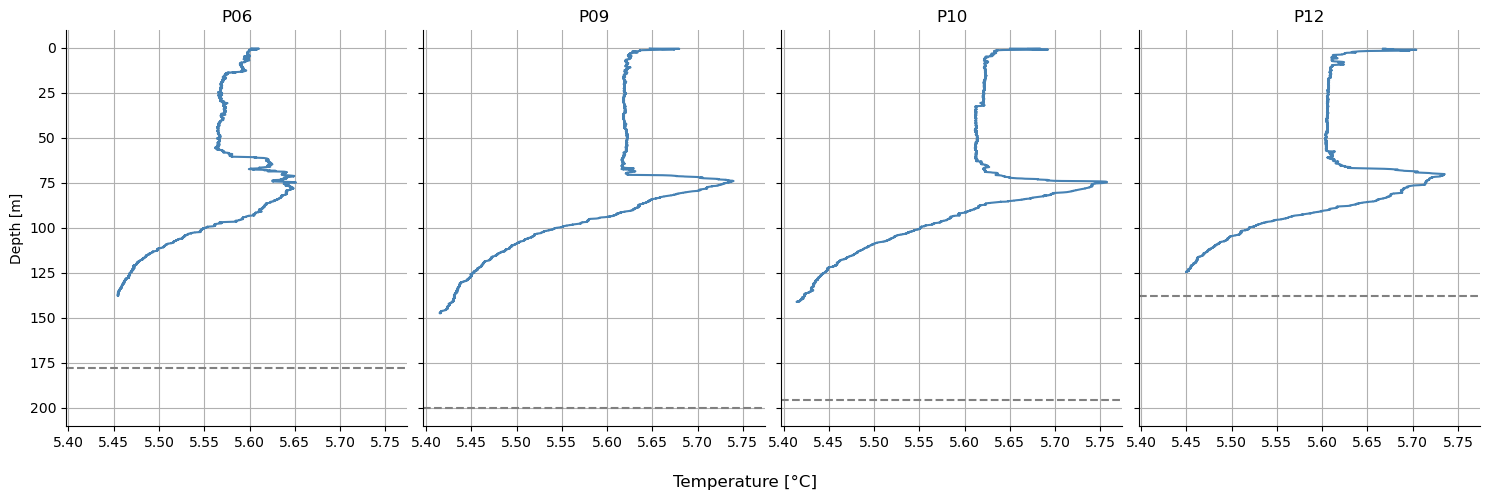

In [16]:
plot_profiles_transect(temp_data, 'Temp')

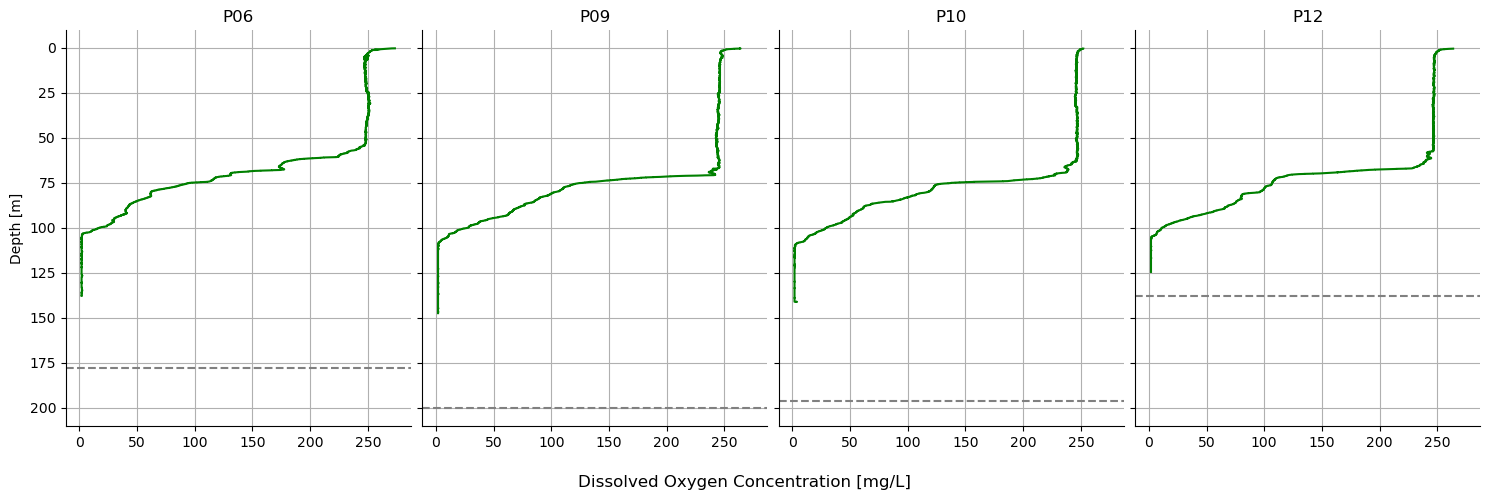

In [17]:
plot_profiles_transect(do_data, 'DO_mg')

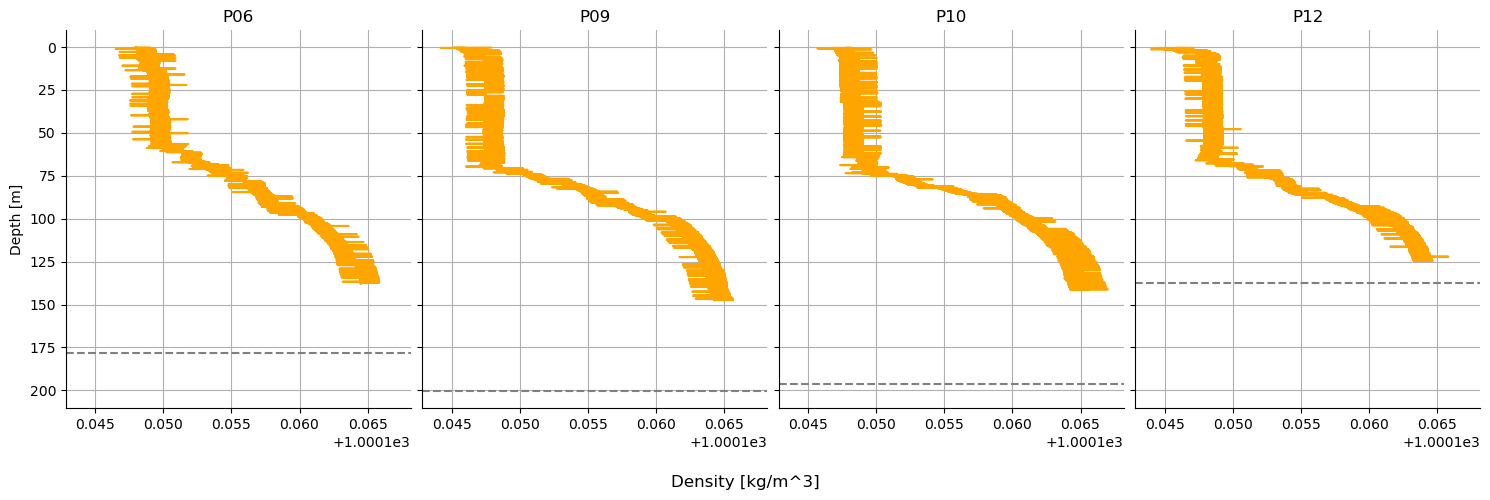

In [18]:
plot_profiles_transect(rho_data, 'rho')

### Moorings

#### LZN

Offset between oxygen logger clock and correct time.  Will need to check for every deployment to apply correction.

In [15]:
lake = 'Zugersee'
location = 'LZN'
year = '2026'
date = '20260114'

t_start = '2025-11-06'
t_end = '2026-01-27'

In [16]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

In [17]:
adcp = adcps[0]

serial_id = adcp['serial_id']
areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)
print(areader.depth)
ds = ds.sel(time=slice(t_start, t_end))


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZN/L0\3U420.000 ...
137.77456665039062


In [18]:
ds['roll'].mean(), ds['pitch'].mean()

(<xarray.DataArray 'roll' ()> Size: 8B
 array(-0.76281691),
 <xarray.DataArray 'pitch' ()> Size: 8B
 array(-0.4101193))

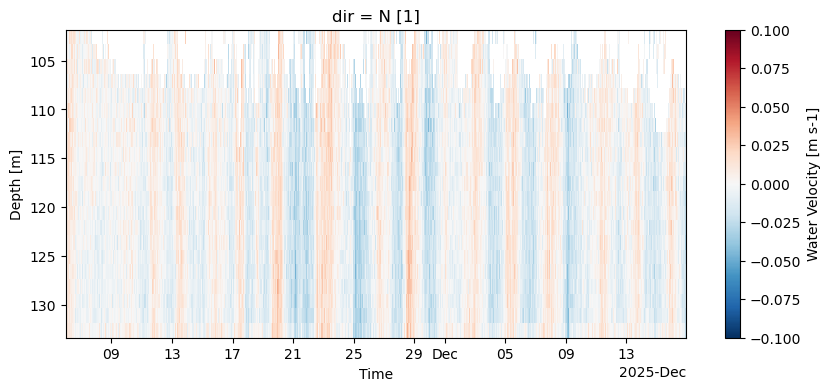

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))

ds.vel.sel(dir='N').plot(cmap='RdBu_r', vmin=-0.1, vmax=0.1, ax=ax)

ax.set_xlabel('Time')
ax.set_ylabel('Depth [m]')
ax.invert_yaxis()
plt.show()

In [26]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.fpath = fpath
    oreader.sensor = oreader.get_sensor_type()
    oreader.mab = oreader.get_mab()
    oreader.depth = oreader.set_depth()

    ds = oreader.load_from_L0()

    # fix clock offset
    if serial_id == '797278':
        t0 = pd.Timestamp('2025-10-24 12:00:00')
        dt = t0 - ds.time.values[0]
        ds = ds.assign_coords(time=ds.time + dt)
    elif serial_id == '294627':
        t0 = pd.Timestamp('2025-10-24 11:58:00')
        dt = t0 - ds.time.values[0]
        ds = ds.assign_coords(time=ds.time + dt)

    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] -= ds['d_oxygen_conc'].min().item()    # subtract minimum
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain[:-1])

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


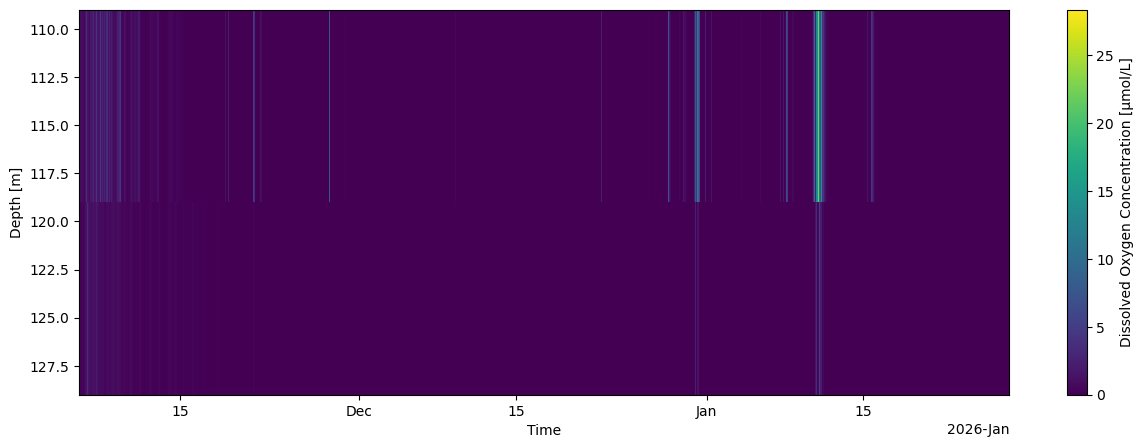

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

ax.invert_yaxis()
plt.show()

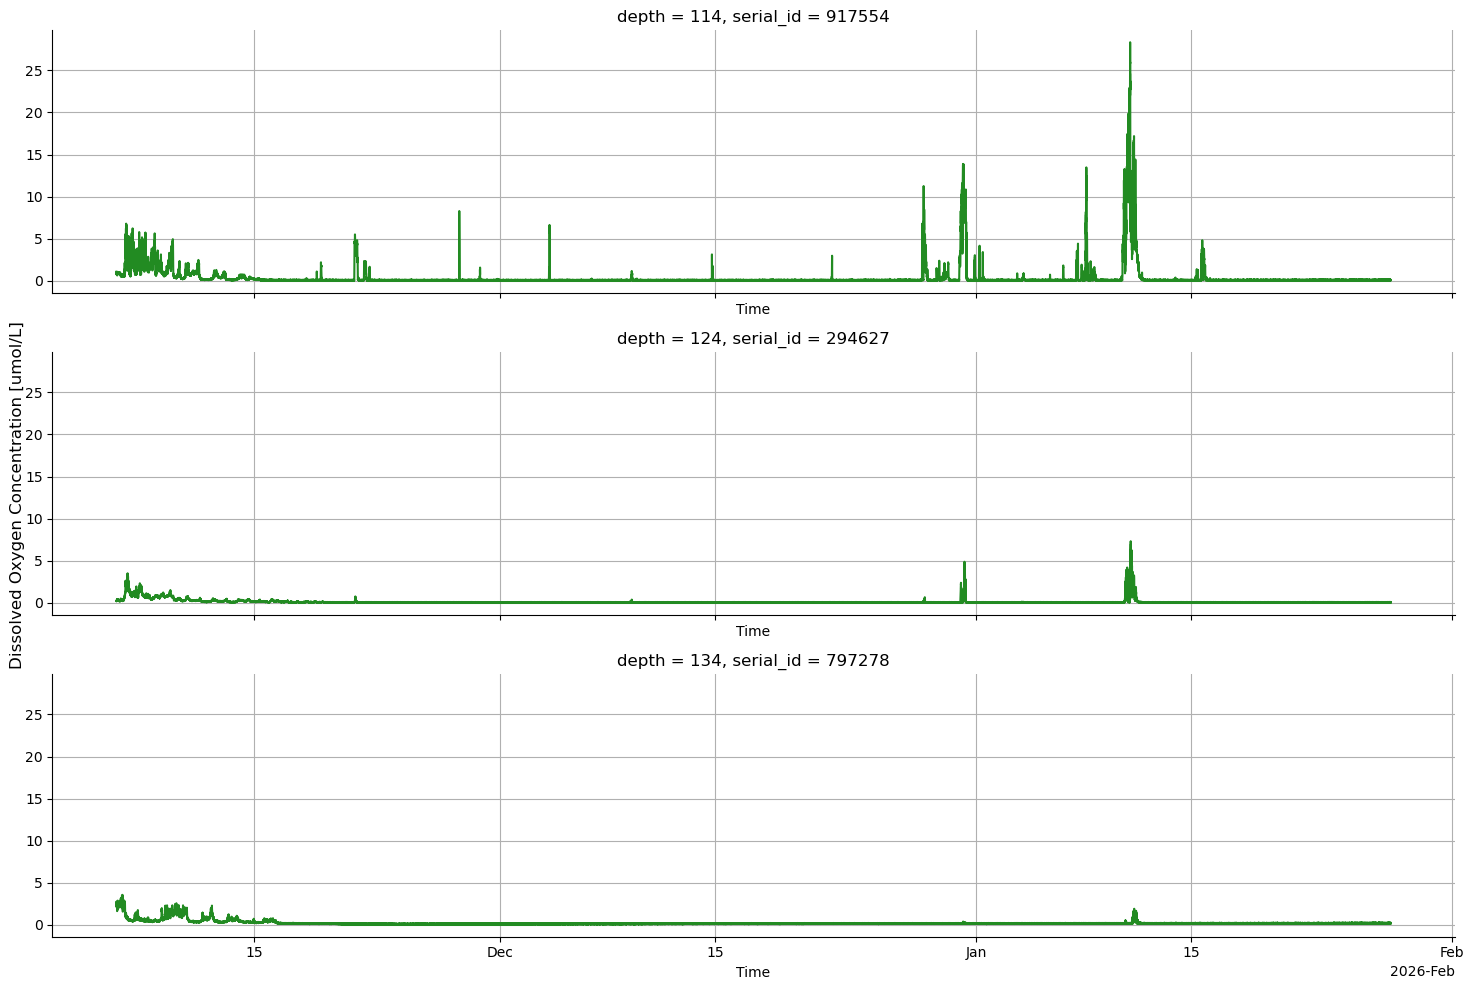

In [28]:
fig, ax = plt.subplots(nrows=len(ds_chain), ncols=1, figsize=(15, 10), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    #ax[i].plot(np.arange(len(d['d_oxygen_conc'][20000:-1000])), d['d_oxygen_conc'][20000:-1000], color='forestgreen')
    d['d_oxygen_conc'].plot(color='forestgreen', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Dissolved Oxygen Concentration [umol/L]')
plt.tight_layout()
plt.show()

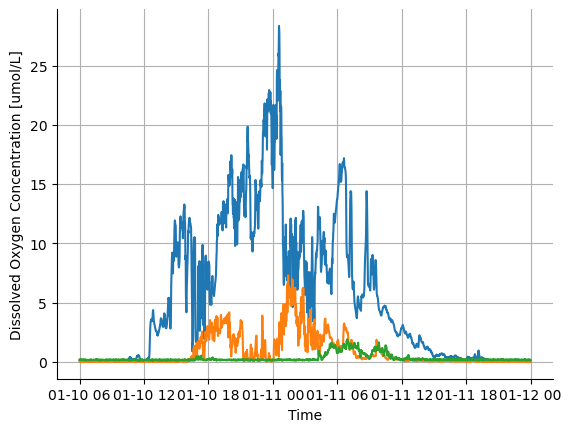

In [29]:
fig, ax = plt.subplots()

for i, d in enumerate(ds_chain):
    dat = d.sel(time=slice('2026-01-10 06:00', '2026-01-11'))
    ax.plot(dat['time'], dat['d_oxygen_conc'])
    #d['d_oxygen_conc'].sel(time=slice('2026-01-10 06:00', '2026-01-11')).plot(ax=ax)

ax.set_xlabel('Time')
ax.set_ylabel('Dissolved Oxygen Concentration [umol/L]')

ax.grid(True)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [14]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    try:
        treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
        ds = treader.load_from_L0()
        ds = ds.sel(time=slice(t_start, t_end))
        ds_chain.append(ds)
    except Exception as e:
        print(f"Could not load data for thermistor {serial_id}: {e}")

ds_temp = mreader.create_instrument_chain(ds_chain)

NameError: name 'thermistors' is not defined

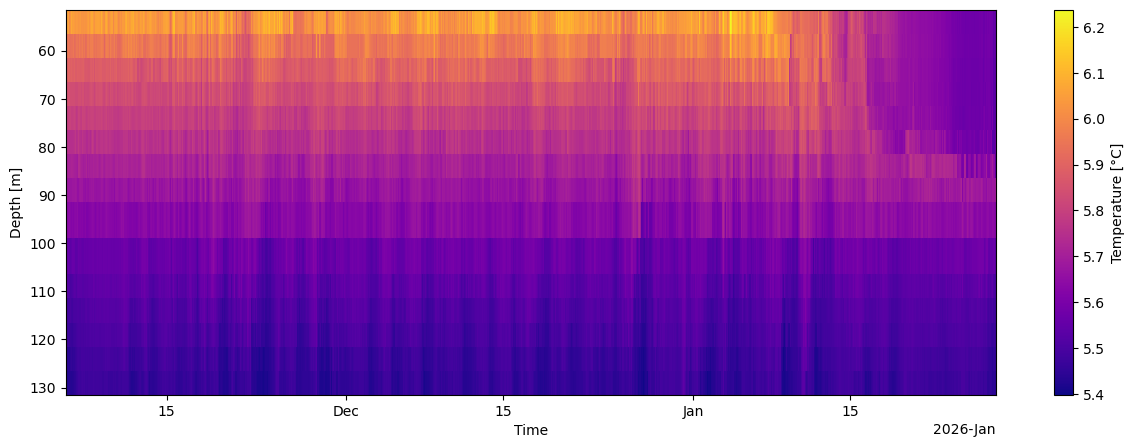

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_temp.temp.plot(cmap='plasma', ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Temperature [°C]")

ax.invert_yaxis()
plt.show()

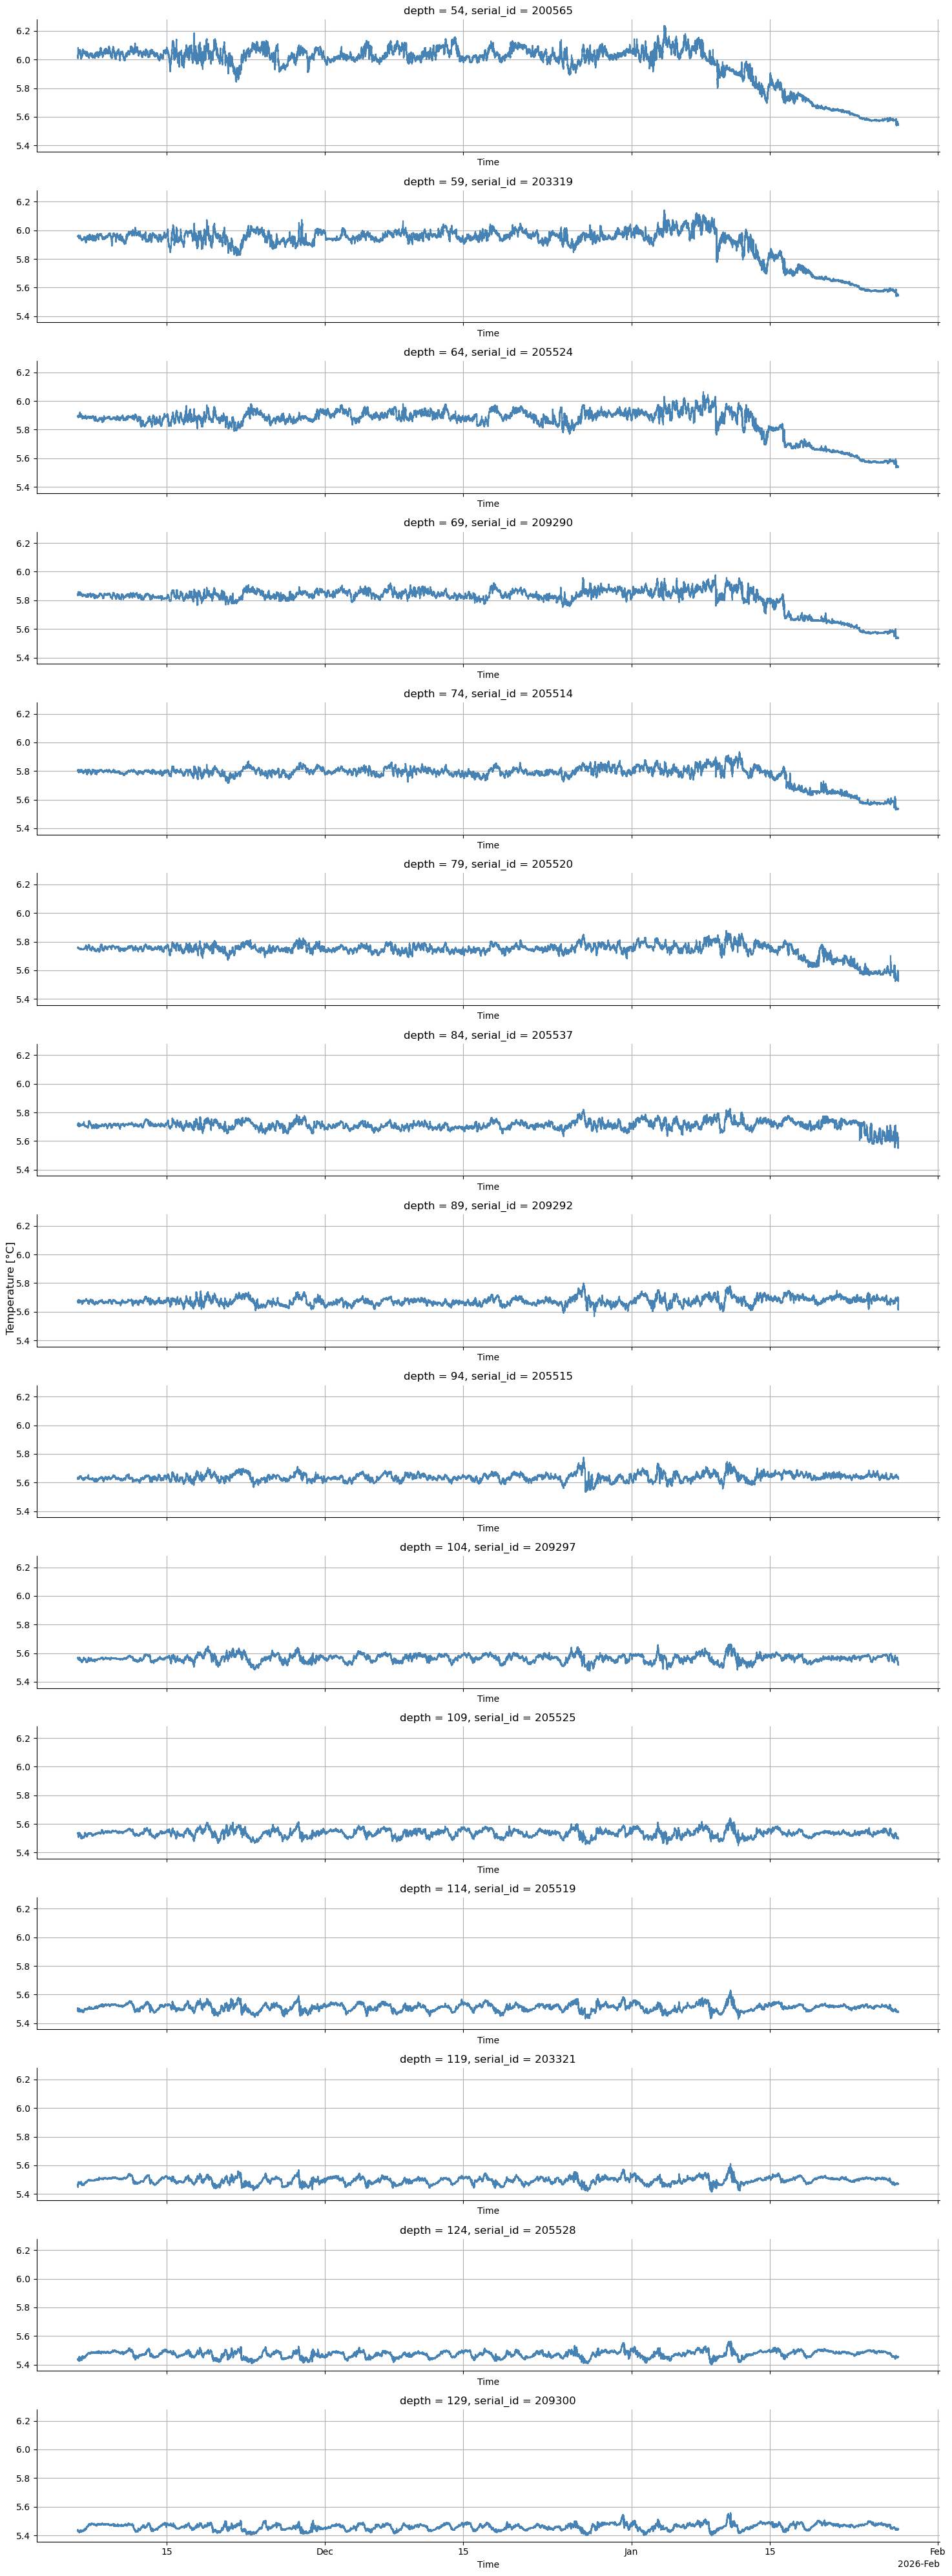

In [32]:
fig, ax = plt.subplots(nrows=len(ds_chain), ncols=1, figsize=(15, 40), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['temp'].plot(color='steelblue', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Temperature [°C]')
plt.tight_layout()
plt.show()

#### LZE

None of the data passes the quality assurance tests, need to look at which tests fail.  Only data until the 12th of December.  ADCP pressure says 148 m depth, which is deeper than planned (~ 138 m).

In [25]:
def plot_adcp(ds):
    fig, ax = plt.subplots(figsize=(10, 4))

    ds.vel.sel(dir='N').plot(cmap='RdBu_r', vmin=-0.1, vmax=0.1, ax=ax)

    ax.set_xlabel('Time')
    ax.set_ylabel('Depth [m]')
    ax.invert_yaxis()
    plt.show()

In [19]:
lake = 'Zugersee'
location = 'LZE'
year = '2026'
date = '20260114'

t_start = '2025-11-01'
t_end = '2026-01-29'

In [20]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()

In [21]:
adcps

[{'instrument': 'adcp', 'serial_id': '16576', 'mab': 1, 'comments': 'up'}]

In [22]:
adcp = adcps[0]

serial_id = adcp['serial_id']
areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)
print(areader.depth)
ds = ds.sel(time=slice(t_start, t_end))


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZE/L0\3U16576.000 ...
148.59567260742188


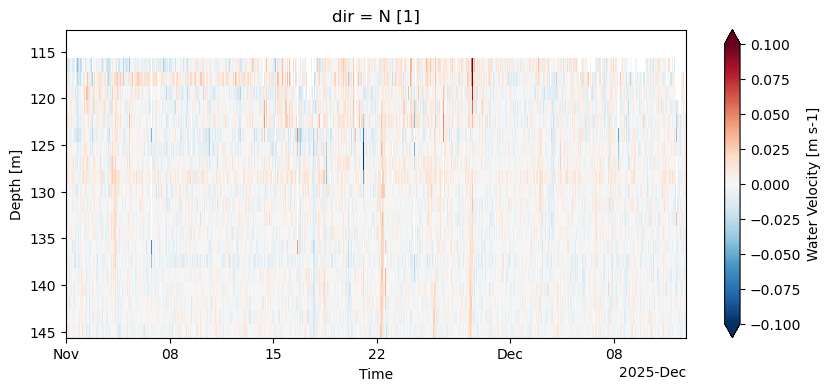

In [26]:
plot_adcp(ds)